## Run 1

In [1]:
## LOADING DATA

import pickle

# Load ribociclib data from data/preprocessed 

with open('data/preprocessed/palbociclib_data.pkl', 'rb') as f:
    palbociclib_data = pickle.load(f)

In [2]:
import dynmarker.FeatureSelection as fs 

feature_data, label_data = fs.create_feature_and_label(palbociclib_data)

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
# from sklearn import set_config
# set_config(transform_output = "pandas")

import pandas as pd 

from functools import partial

scaler = Normalizer()
feature_selector = SelectKBest(score_func=f_regression, k=20)
model = ElasticNet()

scores, pval = f_regression(feature_data, label_data)
scores # score for each feature at their respective index

K = 20
mrmr_score_func = partial(fs.mrmr_select_fcq_sklearn, K=K)
mrmr_selector = SelectKBest(mrmr_score_func, k=K)


In [4]:
pipe = Pipeline([('feature_selector', feature_selector), ('regressor', model)])

scores = cross_val_score(pipe, feature_data, label_data, cv=5, scoring='neg_mean_squared_error')

print(f'NORM mean: {-scores.mean():.4f}, std: {scores.std():.4f}')

NORM mean: 1.7761, std: 0.0980


## Run 2 

In [1]:
## LOADING DATA

import pickle
import dynmarker.FeatureSelection as fs 

# Load palbociclib data from data/preprocessed 

with open('data/preprocessed/palbociclib_data.pkl', 'rb') as f:
    palbociclib_data = pickle.load(f)


In [2]:

feature_data, label_data = fs.create_feature_and_label(palbociclib_data)
y_std = label_data.std()
y_std


1.5952913449402224

In [8]:

import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import LinearSVR, LinearSVC, SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score

from dynmarker.EvaluationPipeline import EvaluationPipeline
from dynmarker.FeatureSelection import example_run_model_func


In [9]:
random_eval = EvaluationPipeline()
random_eval.set_function(example_run_model_func)

In [10]:
random_eval.run_function(feature_data, label_data, 10, k_ranges=range(1,201,10), model_list=[LinearRegression(), Lasso(), ElasticNet()], n_cores=6)

--- Finished LinearRegression using 6 cores ---
--- Finished Lasso using 6 cores ---
--- Finished ElasticNet using 6 cores ---


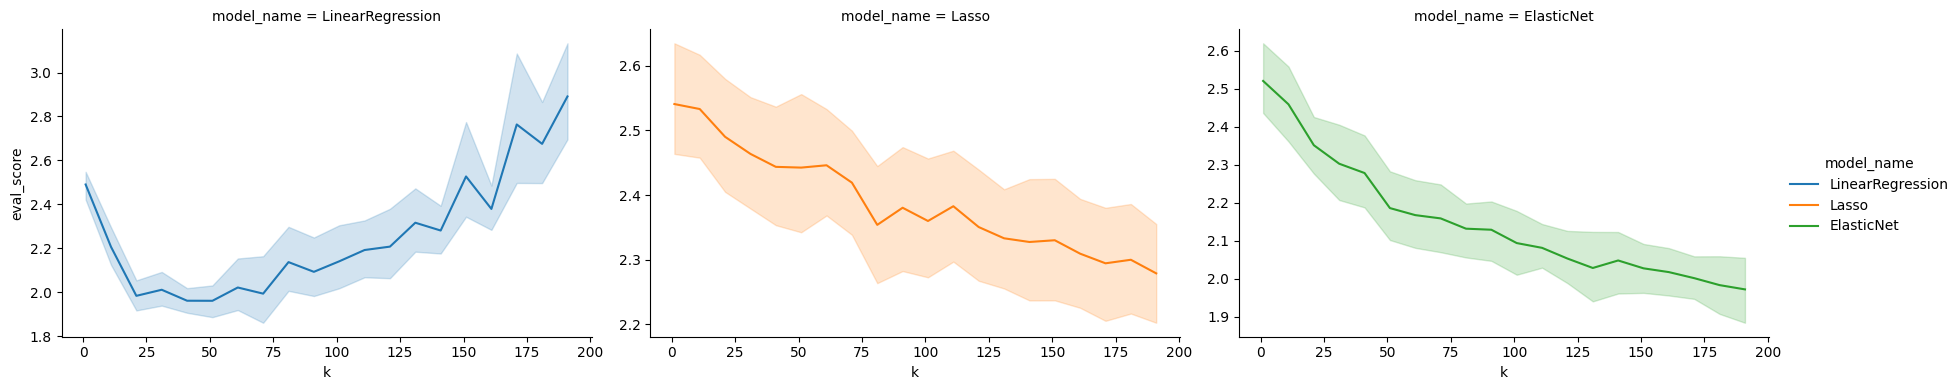

In [11]:
# plot a line plot the average score and std for each k value over the i iterations, show error bar as std

import matplotlib.pyplot as plt
import seaborn as sns

evaluation_df_lite = random_eval.evaluation_df

# get rid of the outliers, 20 times the value of the label data's standard deviation is the cut-off
processed_evaluation_df = evaluation_df_lite[evaluation_df_lite['eval_score'] < y_std*5]
# processed_evaluation_df = evaluation_df_lite

# plot each model on the different figure, multi-figure plot

g = sns.FacetGrid(processed_evaluation_df, col='model_name', col_wrap=3, hue='model_name', height=4, aspect=1.5, sharey=False)
g.map(sns.lineplot, 'k', 'eval_score')
g.add_legend()
# plt.grid()
plt.show()

In [12]:
# train test split using MLPRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.2, random_state=42)

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, predictions)

print(score)

2.3337973445311193


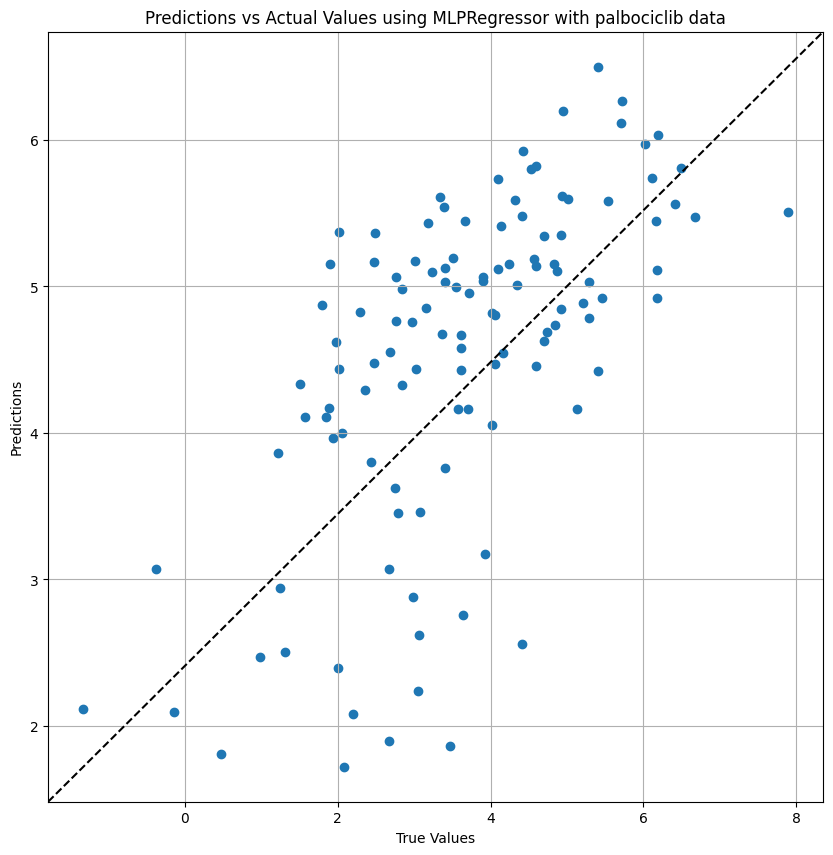

Correlation coefficient: 0.6294, p-value: 0.0000


In [24]:
# plot the predictions vs the actual values

import matplotlib.pyplot as plt

# add in a line of y=x

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='k')

# title
plt.title('Predictions vs Actual Values using MLPRegressor with palbociclib data')
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid()
plt.show()

# pearson correlation coefficient

from scipy.stats import pearsonr

corr, p_val = pearsonr(y_test, predictions)

# print the correlation coefficient and p-value
print(f'Correlation coefficient: {corr:.4f}, p-value: {p_val:.4f}')



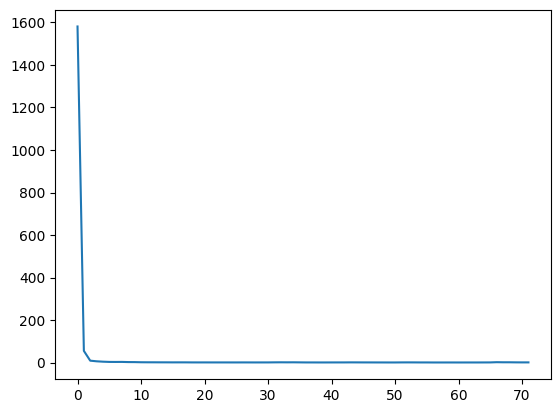

In [22]:
# show loss curve

plt.plot(mlp.loss_curve_)
